<h1>CS4619: Artificial Intelligence II</h1>
<h1>Transformers</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import add

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.initializers import Constant

from tensorflow import convert_to_tensor, string

2023-08-02 13:08:29.021986: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv("../datasets/dataset_5000_reviews.csv")

In [4]:
# Train/test split
split_point = int(len(df) * 0.8)
dev_X = df["review"][:split_point]
test_X = df["review"][split_point:] 

# Target values, encoded and converted to a 1D numpy array
label_encoder = LabelEncoder()
label_encoder.fit(df["sentiment"])
dev_y = label_encoder.transform(df["sentiment"][:split_point])
test_y = label_encoder.transform(df["sentiment"][split_point:])

In [5]:
max_tokens = 20000
max_length = 200

In [6]:
# Create the count vectorization layer, and call adapt on the text-only dataset to create the vocabulary.
vectorization_layer = TextVectorization(output_mode="int", max_tokens=max_tokens, output_sequence_length=max_length)
vectorization_layer.adapt(convert_to_tensor(dev_X))

In [7]:
vocabulary = vectorization_layer.get_vocabulary()

In [8]:
word_index = dict(zip(vocabulary, range(len(vocabulary))))

In [9]:
# Throughout the code, we will use 100-dimensional word embeddings (including the pretrained GloVe embeddings later)
embedding_dimension = 100

In [10]:
# Parse the GloVe word embeddings file: produces a dictionary from words to their vectors

path = "../datasets/glove.6B.100d.txt" # Edit this to point to your copy of the file

embeddings_index = {}
f = open(path)
for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs
f.close()

In [11]:
# Create a matrix that associates the words that we obtained from the IMDB reviews earlier 
# (in the vocabulary) with their GloVe word embeddings

embedding_matrix = np.zeros((max_tokens, embedding_dimension)) 
for word, i in word_index.items():
    if i < max_tokens:
        word_embedding = embeddings_index.get(word)
        if word_embedding is not None:
            embedding_matrix[i] = word_embedding

<h1>Acknowledgements</h1>
<ul>
    <li>A few of the examples owe a debt to Chollet's book (2nd edition). The table also comes from Chollet's book.
    </li>
    <li>The colourful diagrams are my own invention but were improved by seeing similar diagrams in materials produced by Sebastian Raschka.</li>
</ul>

<h1>Introduction</h1>
<ul>
    <li>We have learned a little about recurrent neural networks (RNNs) and their applications in natural language processing (NLP).</li>
    <li>There have been many improvements to RNNs, such as beam search, bidirectional RNNs and attention mechanisms.</li>
    <li>But a new architecture has emerged that often outperforms RNNs: the <b>transformer</b> architecture.
        <ul>
            <li>Ashish Vaswani et al: <i>Attention is all you need.</i> In Proceedings of the 31st International Conference on Neural Information Processing Systems, 2017. (<a href="https://arxiv.org/abs/1706.03762">https://arxiv.org/abs/1706.03762</a>) 
        </ul>
    </li>
    <li>Transformers typically use <b>self-attention</b> (see below).</li>
    <li>They do not contain any mechanisms for processing input sequentially: no recurrent layers, no 1D-convolutional layers, &hellip; They receive the input sequence all in one go.</li>
</ul>

<h1>Self-Attention</h1>
<ul>
    <li>The idea of self-attention is to model the dependencies between elements of the input sequence.
        <ul>
            <li>Indeed, the self-attention mechanism enables a transformer to capture <em>long-range</em> dependencies between elements of the input sequence.</li>
            <li>Recall that this was something that caused difficulties for RNNs. Even using LSTMs and GRUs, which were developed to help overcome these difficulties, the problem still remained. 
        </ul>
    </li>
    <li>Consider a word such as ``date''. We have a single word embedding for this word: a vector of numbers. But this word is ambiguous. Its meaning is context-specific: other words that surround it affect its meaning. Consider:
        <ul>
            <li>``I marked the date of the seminar in my calendar.''</li>
            <li>``I enjoyed our date together.''</li>
            <li>``The date seller was not at the market today.''</li>
        </ul>
    </li>
    <li>The idea in self-attention (roughly speaking) is to modify the word embedding based on the word embeddings of the surrounding words.</li>
</ul>

<h2>A Simple Form of Self-Attention</h2>
<ul>
    <li>We start with a simple form of self-attention. Then later we make it more complicated.</li>
    <li>Assume we have an input sentence and we compute the word embedding for each word in that input sentence: $\v{x}_{(1)}, \v{x}_{(2)}, \ldots, \v{x}_{(\mathit{max\_length})}$. Below, as before, for simplicity of exposition, I will often write ``word'' when strictly I should write ``word embedding''.
    <li>In overview, we do the following for each word $\v{x}_{(i)}$ in the input sequence:
        <ul>
            <li>Compute attention weights $\alpha_{ij}$: simply, each weight is the similarity (dot product) between word $\v{x}_{(i)}$ and every word $\v{x}_{(j)}$ for $j=1\ldots\mathit{max\_length}$ in the input sequence.
                $$\alpha_{ij} = \v{x}_{(i)}\v{x}_{(j)}$$
                (So, if you like, $\alpha_{ij}$ is the relevance of word $j$ to word $i$.)<br />
                Note that these 'weights' are calculated; they are not learned. 
            </li>
            <li>Normalise the weights: for this, we use softmax.</li>
            <li>Compute a context-aware embedding $\v{z}_{(i)}$ for $\v{x}_{(i)}$: the weighted sum of all the word embeddings in the input sequence.
                $$\v{z}_{(i)} = \sum_{j=1}^{\mathit{max\_length}} \alpha_{ij}\v{x}_{(j)}$$
            </li>
        </ul>
    </li>
</ul>

<h3>Example</h3>
<ul>
    <li>Suppose the input sequence is ``the train left the station on time''.</li>
    <li>We get the word embeddings for each word.</li>
    <li>Suppose the current word is word 5: ``station''.</li>
    <li>We compute the similarities (dot products) between the word embedding for ``station'' and the word embeddings for all the words in the input sentence. Suppose this gives the following:
        $$\cv{0.2\\0.8\\0.6\\0.2\\1.0\\0.2\\0.3}$$
        So the similarity between ``train'' and ``station'', for example, is 0.8. Why do we have a 1.0 in there?
    </li>
    <li>Then we normalize using softmax to obtain (roughly):
        $$\cv{0.10\\0.19\\0.15\\0.10\\0.23\\0.10\\0.11}$$
    </li>
    <li>Finally, the context-aware embedding for ``station'' is the weighted sum of the word embeddings:
        $$\v{z}_{(5)} = \mathit{sum}\left(\cv{
        0.10 \times \v{x}_{(1)}\\
        0.19 \times \v{x}_{(2)}\\
        0.15 \times \v{x}_{(3)}\\
        0.10 \times \v{x}_{(4)}\\
        0.23 \times \v{x}_{(5)}\\
        0.10 \times \v{x}_{(6)}\\
        0.11 \times \v{x}_{(7)}}\right)$$
    </li>
    <li>You can see that now we have an embedding for ``station'' that has been modified by its context, i.e. by the other words in the sentence.</li>
</ul>

<h3>Vectorization</h3>
<ul>
    <li>Above, we saw the calculations for one of the words (``station'').</li>
    <li>But, we don't need to do this one word at a time.</li>
    <li>We can vectorize:
        <ul>
            <li>Put the word embeddings into a matrix $\v{X}$. E.g. if there are 7 words and the word embedding dimension is 100, then $\v{X}$ is a $7 \times 100$ matrix.
            <li>Compute the similarities $\v{A}$ between all pairs of words by multiplying $\v{X}$ with itself (acutally with its transpose). In the example, this would give a $7 \times 7$ matrix.</li>
            <li>Normalize each column of the similarity matrix $\v{A}$ using softmax.</li>
            <li>Compute the context-aware vectors for all the words in the input sentence using a matrix multiplication between the normalized similarity matrix and a matrix of the word embeddings:
                $$\v{Z} = \v{A}\v{X}$$
            </li>
        </ul>
    </li>
</ul>

<img src="images/self_attention1.png" />

<h2>A More Advanced Form of Self-Attention</h2>
<ul>
    <li>The simple form of self-attention that we studied above does not have any learnable parameters.</li>
    <li>We introduce three additional weight matrices, $\v{U}_q$, $\v{U}_k$ and $\v{U}_v$.
        <ul>
            <li>They are initialized at random, and then modified during back-prop.<br />
                Note that these weights are learned &mdash; unlike the ones in $\v{A}$.</li>
            <li>Let the embedding dimension of the word embeddings be $d$. Then, it is common for $\v{U}_q$, $\v{U}_k$ and $\v{U}_v$ to be $d \times d$ matrices. And this is what we will assume in our presentation here.</li>
            <li>(Advanced, ignore: more generally, we can choose values $d_k$ and $d_v$ and then $\v{U}_q$ and $\v{U}_k$ can be $d_k \times d$, and $\v{U}_v$ can be $d_v \times d$.)</li>
        </ul>
    </li>
    <li>How do we use these weight matrices?
        <ul>
            <li>We multiply the word embeddings $\v{x}_{(i)}$ by each of the matrices:
                $$\v{q}_{(i)} = \v{U}_q\v{x}_{(i)}$$
                $$\v{k}_{(i)} = \v{U}_k\v{x}_{(i)}$$
                $$\v{v}_{(i)} = \v{U}_v\v{x}_{(i)}$$
            </li>
            <li>Previously, we computed the weights as the similarity (dot product) of the word embeddings: $\alpha_{ij} = \v{x}_{(i)}\v{x}_{(j)}$. But, now:
                $$\alpha_{ij} = \v{q}_{(i)}\v{k}_{(j)}$$
            </li>
            <li>Then, we normalise the weights, as before: softmax. (Advanced, ignore: In fact, in transformers, we scale the weights by multiplying them by $1/\sqrt{d}$ before we take the softmax. This gives a 'smoother' softmax distrbution.)</li>
            <li>Finally, we compute a context-aware embedding. Previously, we computed a weighted sum: $\v{z}_{(i)} = \sum_{j=1}^{\mathit{max\_length}} \alpha_{ij}\v{x}_{(j)}$. But, now:
              $$\v{z}_{(i)} = \sum_{j=1}^{\mathit{max\_length}} \alpha_{ij}\v{v}_{(j)}$$
            </li>
        </ul>
    </li>
</ul>

<img src="images/self_attention2.png" />

<h3>Query, key and value</h3>
<ul>
    <li>For each word, we computed three vectors, $\v{q}_{(i)}$, $\v{k}_{(i)}$ and $\v{v}_{(i)}$.</li>
    <li>People refer to these three as the <b>query</b>, <b>key</b> and <b>value</b> vectors.</li>
    <li>Why? The inventors of transformers needed three names. They hijacked three names from the field of non-relational databases. In a non-relational database, we enter a query, it is matched against a key, and a value is retrieved. If we are being charitable, we can see that in transformers query vectors are matched with key vectors when we compute similarities, and value vectors are part of the final result. So there is a tenuous connection.</li>
     <li>For me, these names are unhelpful. They might just as well have called them Huey, Dewey and Louie in honour of Donald Duck's nephews!
    </li>
    <li>(Advanced, ignore: Above, we used $\v{x}_{(i)}$ for calculating the query, key and value. This is what we do for sequence classification, e.g. for sentiment analysis. But, in fact, you could use a different vector for each. For example, in machine translation between English and French, a training example will have both an English sentence and a French sentence. You might use French words when computing the query, and English words when computing the keys and values. If you do this, then you are no longer really doing <em>self</em>-attention.)</li>
</ul>

<h2>Multi-Head Attention</h2>
<ul>
    <li>Let's refer to the three matrices $\v{U}_q$, $\v{U}_k$ and $\v{U}_v$ as a <b>head</b>. Then, what we have described is a transformer that has a single head.</li>
    <li>But transformers use multi-head attention: they use multiple heads. In other words, if we have $h$ heads then we have $h$ sets of these matrices:
        <ul>
            <li>$\v{U}_{q_1}$, $\v{U}_{k_1}$, $\v{U}_{v_1}$</li>
            <li>$\v{U}_{q_2}$, $\v{U}_{k_2}$, $\v{U}_{v_2}$</li>
            <li>&hellip;</li>
            <li>$\v{U}_{q_h}$, $\v{U}_{k_h}$, $\v{U}_{v_h}$</li>
        </ul>
    </li>
    <li>Now, instead of computing one query vector, key vector and value vector per word, we compute $h$ of them.</li>
    <li>Why do we want multiple heads? It gives the transformer more parameters and an opportunity to learn $h$ different representations. It's a bit like why we have multiple feature maps in a convolutional layer.
        <figure style="text-align: center;">
            <img src="images/attention_examples.png" />
            <figcaption>Evidence that different heads learn to perform different tasks.<br />
                Taken from the <i>Attention is all you need</i> paper
            </figcaption>
        </figure>
    </li>
    <li>(Advanced, ignore: In fact, instead of having $h$ sets of matrices, we combine them into just 3 matrices and use Boolean masks to access regions of the matrices. This improves efficiency: it means we can use just one matrix multiplication instead of $h$ matrix multiplications.)</li>
    <li>The outputs of the multiple heads are concatenated.</li>
</ul>

<figure style="text-align: center;">
    <img src="images/multi_head_attention.png" />
    <figcaption>Taken from the <i>Attention is all you need</i> paper<br />
        (Linear = Dense layers)<br />
        (The optional Mask allows you to build transformers where attention is constrained, e.g. to previous words, instead of all words)
    </figcaption>
</figure>

<h2>Positional Encoding</h2>
<h3>Sets, not sequences</h3>
<ul>
    <li>Self-attention is a <em>set</em>-processing mechanism, not a <em>sequence</em>-processing mechanism.
        <ul>
            <li>We did not feed in an input sentence $\v{x}_{(1)}, \v{x}_{(2)}, \ldots, \v{x}_{(\mathit{max\_length})}$ one word at a time.</li>
            <li>We treated the input sentence as a matrix, where each row of the matrix is one element of the input sequence.
                And the whole matrix is fed in as a single input in one go.
            </li>
            <li>This is great for parallelization (although we should acknowledge that transformers are quite expensive to train, even when parallelized).</li>
            <li>But it means that the input is now a set (a set of rows), not a sequence!
                <ul>
                    <li>You could shuffle the rows and it will make no difference: you will calculate the same pairwise similarities and the same context-aware representations.
                </ul>
            </li>
        </ul>
    </li>
    <li>We don't want this! We have lost word ordering. It makes ``Dogs hate cats'' no different from ``Cats hate dogs'' &mdash; both are sets (matrices) containing the word embeddings for ``cats'', ``dogs'' and ``hates''.
    </li>
    <li>Transformers need an extra mechanism to re-inject word ordering information.
        <table>
            <tr><th></th><th>Word order awareness</th><th>Context-awareness</th></tr>
            <tr><th>Bag-of-words (unigrams)</th><td>No</td><td>No</td></tr>
            <tr><th>Bag-of-words (bigrams)</th><td>Very limited</td><td>No</td></tr>
            <tr><th>RNN</th><td>Yes</td><td>No</td></tr>
            <tr><th>Self-attention</th><td>No</td><td>Yes</td></tr>
            <tr><th>Transformer</th><td>Yes</td><td>Yes</td></tr>
        </table>
    </li>
</ul>

<h3>Re-injecting word order information</h3>
<ul>
    <li>To re-inject word order information, we will include the word's position in the input sentence in each word embedding. Let's consider three ways of doing this.</li>
    <li>Simple: Concatenate the word position to the word embedding. 
        <ul>
            <li>Concatenate 0 to the word embedding of the first word.</li>
            <li>Concatenate 1 to the word embedding of the second word.</li>
            <li>And so on.</li>
        </ul>
        This is not ideal: these integers would dominate the values in the word embeddings, making the word embeddings themselves negligble.
    </li>
    <li>The original transformer: Add the sine and/or cosine of the position.
        <ul>
            <li>This means you add values in the range $[-1, 1]$</li>
            <li>The values vary cyclically.</li>
        </ul>
    </li>
    <li>Positional embedding: learn an embedding of the position.
        <ul>
            <li>We know that an embedding layer maps from a word index (i.e. its index in the vocabulary) to a $d$-dimensional vector.</li>
            <li>So why not use another embedding layer to map from word positions (i.e. where a word is in the sentence) to another $d$-dimensional vector.</li>
            <li>Then add the word embedding and the positional embedding.</li>
        </ul>
    </li>
</ul>

<h2>Transformers</h2>
<ul>
    <li>Transformers put all these ideas together with others. Details unimportant in CS4619.
        <ul>
            <li>They add some dense layers.</li>
            <li>They add some skip links (see the final lecture of AI1 to remind yourself what these are).</li>
            <li>They add layer normalization. Layer normalization is similar to, but different from batch normalization. Batch normalization computes means and standard deviatons from all examples in a mini-batch, but this does not work well for sequence data. Instead, layer normalization normalizes each input sequence independently from the others. In other words, it computes means and standard deviations from all inputs in each sequence.</li>
        </ul>
    </li>
    <li>Here is the diagram from the original paper:
        <figure style="text-align: center;">
            <img src="images/transformer_encoder.png" />
        </figure>
        They used 8 heads and a stack of 6 of these layers. 
    </li>
    <li>In fact, what we have discussed so far (and the diagram) is just the transformer encoder. You'll then want more layers to do your task.
        <ul>
            <li>E.g. for sentiment analysis (negative/positive, or negative/neutral/positive), you want a final dense layer containing two or three neurons as your output layer.</li>
            <li>E.g. for sequence-to-sequence tasks, such as Machine Translation, code completion or question-answering, then you will want to connect your transformer encoder to a transformer decoder.</li>
        </ul>
    </li>
</ul>

<h1>IMDB Reviews, One More Time</h1>
<ul>
    <li>I have implemented the transformer architecture using Keras's <code>MultiHeadAttention</code> layer.</li>
    <li>Question: Looking at the code, how did I achieve <em>self</em>-attention?</li>
    <li>Initially, I included positional embedding using Keras NLP's <code>PositionEmbedding</code> layer.
        <ul>
            <li>If you want to run the code with positional embedding, you need to install keras-nlp (see the next cell of this notebook), import <code>keras_nlp.layers.PositionEmbedding</code>, and uncomment the positional embedding layer. 
            </li>
        </ul>
    </li>
    <li>In fact, for this dataset, accuracy is substantially higher without the positional embedding.
        <ul>
            <li>Perhaps the dataset is too small. In any case, it's not wholly surprising since bag-of-words, which also ignores positions, does well on this dataset.</li>
            <li>Hence, I have commented out that layer. You don't need to install anything if you want to run the code as it stands.</li>
        </ul>
    </li>
</ul>

In [12]:
# If you want to try the code with the positional embedding layer then
# a) activate your Python virtual environment and install keras-nlp:
# (venv) $ python3 -m pip install -U keras-nlp
# b) include the following import in your notebook:
# from keras_nlp.layers import PositionEmbedding
# c) uncomment one line of code below

In [13]:
inputs = Input(shape=(1,), dtype=string)
x = vectorization_layer(inputs)
x = Embedding(input_dim=max_tokens, output_dim=embedding_dimension,
            embeddings_initializer=Constant(embedding_matrix), trainable=False)(x)
#x = PositionEmbedding(sequence_length=max_length)(x)
residual = x
x = MultiHeadAttention(num_heads=2, key_dim=64)(x, x)
x = add([x, residual])
x = LayerNormalization()(x)
residual = x
x = Dense(100, activation="relu")(x)
x = add([x, residual])
x = GlobalAveragePooling1D()(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
transformer = Model(inputs, outputs)

transformer.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["acc"])

In [14]:
transformer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 200)                  0         ['input_1[0][0]']             
 ctorization)                                                                                     
                                                                                                  
 embedding (Embedding)       (None, 200, 100)             2000000   ['text_vectorization[0][0]']  
                                                                                                  
 multi_head_attention (Mult  (None, 200, 100)             51684     ['embedding[0][0]',       

In [15]:
transformer_history = transformer.fit(dev_X, dev_y, epochs=10, batch_size=32, validation_split=0.25, 
                          callbacks=[EarlyStopping(monitor="val_loss", patience=2)], verbose=0)

<Axes: >

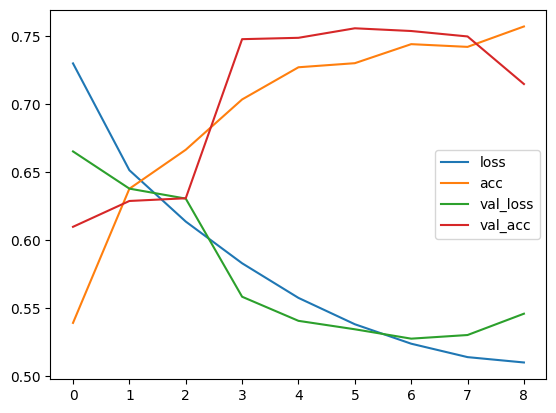

In [16]:
pd.DataFrame(transformer_history.history).plot()